In [1]:
%matplotlib ipympl

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
from itertools import product, combinations
from dataclasses import dataclass
import scipy.spatial as spatial

# Fixing random state for reproducibility
np.random.seed(19680801)

In [2]:
import sys

sys.path.append("..")

from pivot import metric
from pivot.transform import PivotSpace
import pivot.plot as plotting
import pivot.generate as gen
from pivot.query import RangeQuery

%load_ext autoreload
%autoreload 2

In [3]:
def draw_wireframe_cube(center, edge_length, ax=None, **kwargs):
    # from https: stackoverflow.com/questions/11140163/plotting-a-3d-cube-a-sphere-and-a-vector/11156353#11156353
    if ax is None:
        ax = plt.figure().add_subplot(projection="3d")
    if "color" not in kwargs:
        kwargs["color"] = "C0"
    r = [-edge_length / 2, edge_length / 2]
    for s, e in combinations(np.array(list(product(r, r, r))), 2):
        if np.sum(np.abs(s - e)) == r[1] - r[0]:
            s = np.asarray(s) + center
            e = np.asarray(e) + center
            ax.plot3D(*zip(s, e), **kwargs)
            if "label" in kwargs:  # only add one label to the legend
                kwargs.pop("label")

In [4]:
@dataclass
class Pto3DQuery:
    # distances of the query from the three pivots
    q = np.asarray((4, 4, 4))
    # query range in the metric space
    r = 1
    # distances between all pairs of pivots:
    kappa = np.asarray(([0, 3, 4], [3, 0, 7], [4, 7, 0]))

    def is_prunable(self, point):
        """Using Ptolemy's inequality, is the approximated distance between
        `point` and `self.q` high enough to rule the point being a candidate?

        `point` can be either a single point of shape [3] or a point array of
        shape [3, n].
        """
        prune = lambda a, b: self._is_prunable_from_dims(point, a, b)
        return prune(0, 1) & prune(1, 2) & prune(2, 0)

    def _is_prunable_from_dims(self, point, dim_a, dim_b):
        q = self.q
        c_ab = self.r * self.kappa[dim_a, dim_b]
        minimum = 1 / q[dim_b] * (q[dim_a] * point[dim_b] - c_ab)
        maximum = 1 / q[dim_b] * (q[dim_a] * point[dim_b] + c_ab)
        return (minimum < point[dim_a]) & (maximum > point[dim_a])

    def _is_triangle_prunable_from_dims(self, point, dim_a, dim_b):
        pass

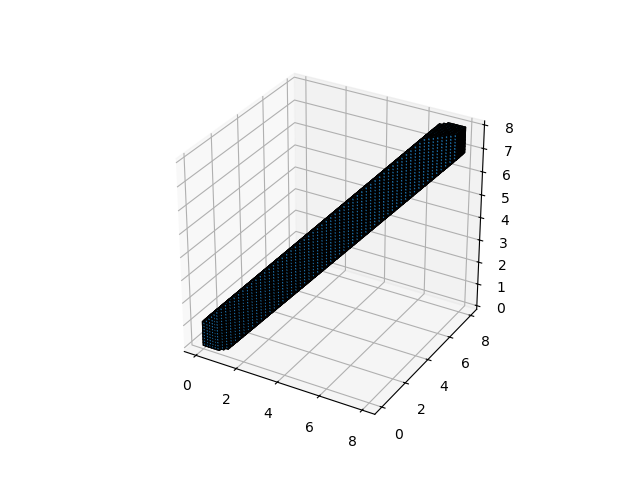

In [5]:
SAMPLES = 60
MAX_RANGE = 8
cube = np.indices([SAMPLES + 1] * 3)
coordinates = cube / SAMPLES * MAX_RANGE
step_size = MAX_RANGE / SAMPLES
point_cloud = coordinates[:, :-1, :-1, :-1] + step_size / 2
point_array = point_cloud.reshape(3, -1)

query = Pto3DQuery()
is_in_query_range = query.is_prunable(point_array)
voxelarray = is_in_query_range.reshape(SAMPLES, SAMPLES, SAMPLES)


ax = plt.figure().add_subplot(projection="3d")
ax.set_aspect("equal")
ax.voxels(*coordinates, voxelarray, edgecolor="k");

In [6]:
# points_in_hull = point_array[:, is_in_query_range]
# hull = spatial.ConvexHull(points_in_hull.T)

# pts = hull.points


# triangles = [
#     (pts[simplex, 0], pts[simplex, 2], pts[simplex,1])
#     for simplex in hull.simplices
# ]
# triangles += [
#     (pts[simplex, 0], pts[simplex, 2], pts[simplex,1])
#     for simplex in hull.simplices
# ]
# triangles = np.asarray(triangles)
# triangles = np.swapaxes(triangles, 1,2)

# from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# draw_args = dict(
#     shade = True,
#     facecolors = "C1",
# )

# ax = plt.figure().add_subplot(projection='3d')
# ax.add_collection(Poly3DCollection(triangles, **draw_args));
# ax.set_xlim(-2,8)
# ax.set_ylim(-2,8)
# ax.set_zlim(-2,8)

# from matplotlib.tri import Triangulation

# Triangulation(triangles)

# ax = plt.figure().add_subplot(projection='3d')
# ax.plot_trisurf(triangles)
# plt.show()

In [8]:
def plot_3d_widget(pos=(0, 0, 0), size=1, ax=None):
    if ax is None:
        ax = plt.gca()
    pos = np.array(pos).reshape(3, 1)
    x1 = np.array([[size], [0], [0]])
    x2 = np.array([[0], [size], [0]])
    x3 = np.array([[0], [0], [size]])

    ax.quiver(*pos, *x1, colors="r")
    ax.quiver(*pos, *x2, colors="g")
    ax.quiver(*pos, *x3, colors="b")

done


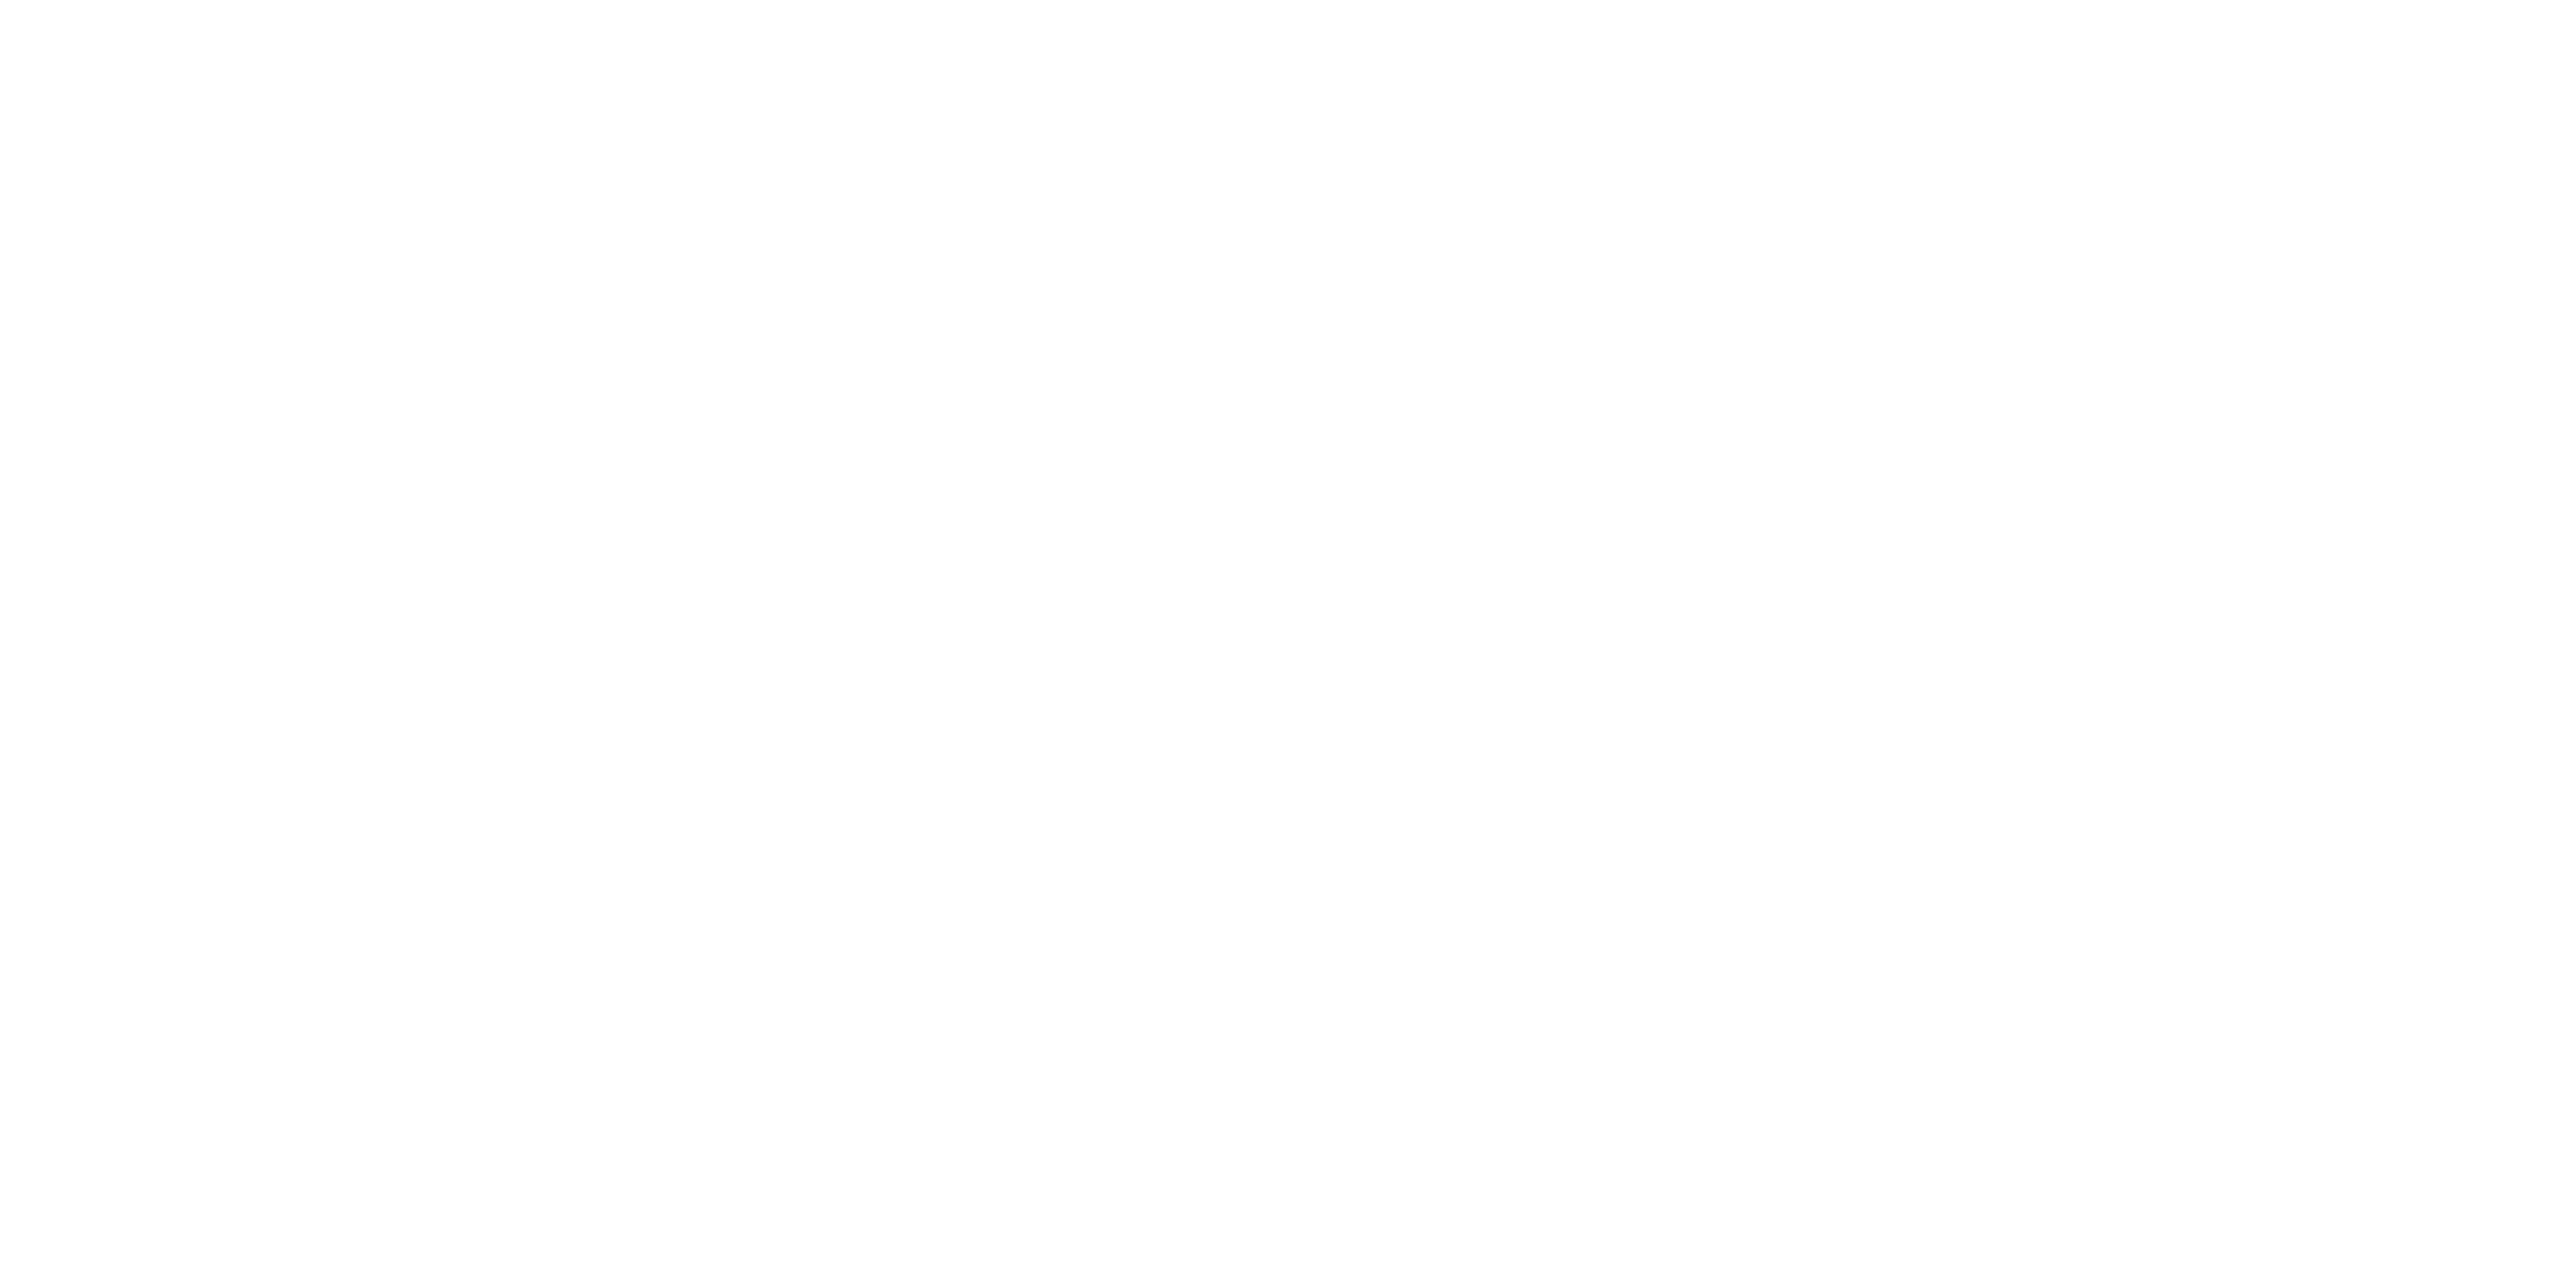

In [9]:
def plot(ax, first=False):
    ax.set_aspect("equal")
    ax.voxels(*coordinates, voxelarray, alpha=0.2)
    ax.scatter(*query.q, label="query")
    ax.scatter(*query.kappa, label="pivots")
    draw_wireframe_cube(query.q, query.r * 2, ax, color="C1", label="query range")

    ax.set_xlim(0, 8)
    ax.set_ylim(0, 8)
    ax.set_zlim(0, 8)

    ax.set_xlabel(r"$\Phi_1$")
    ax.set_ylabel(r"$\Phi_2$")
    ax.set_zlabel(r"$\Phi_3$")

    # where some data has already been plotted to ax
    handles, labels = ax.get_legend_handles_labels()
    voxel_desc = mpatches.Patch(color="C0", label="Pto. candidates")
    handles.append(voxel_desc)

    plot_3d_widget(ax=ax)

    if first:
        # plot the legend
        ax.legend(handles=handles, loc="upper center")


EXPORT = True
# and plot everything
if EXPORT:
    fig = plt.figure(figsize=(10, 5), dpi=300)
else:
    fig = plt.figure(dpi=70)

ax = fig.add_subplot(131, projection="3d")
ax.view_init(25, -60, 0)
plot(ax, first=True)
ax = fig.add_subplot(132, projection="3d")
ax.view_init(-6, -100, 0)
plot(ax)
ax = fig.add_subplot(133, projection="3d")
ax.view_init(-36, -135, 0)
plot(ax)

fig.tight_layout()

if EXPORT:
    fig.savefig("/fig/3d-pto.svg")
    plt.clf()
    print("done")
else:
    fig.show()